In [249]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from src.distributions import SkeGTD

sns.set_style("darkgrid")

def format_distribution(row):
    alpha_str = r"\infty" if row['alpha'] == "inf" else row['alpha']
    base_str = rf"$({alpha_str}, {row['skew']})$"
    return base_str + " ht." if row['heteroscedasticity'] else base_str

# Distributions

We first display the skewed generalized normal distribution for some combinations of parameters.

<Axes: xlabel='x', ylabel='cdf'>

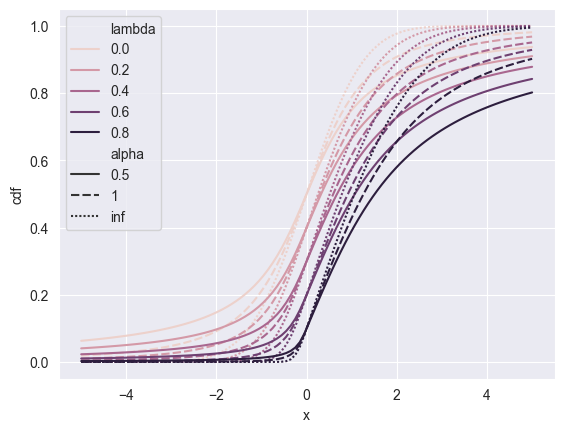

In [255]:
x = np.linspace(-5, 5, 100)
xs = []
cdfs = []
alphas = []
lambdas = []
rng = np.random.default_rng(1)
for a in [.5, 1, np.inf]:
    for l in [0, .2, .4, .6, .8]:
        dist = SkeGTD(a, l, rng)
        xs += x.tolist()    
        cdfs += dist.cdf(x).tolist()
        alphas += [a if a < np.inf else "inf"]*x.size
        lambdas += [l]*x.size

sns.lineplot(
    pd.DataFrame({"alpha": alphas, "lambda": lambdas, "x": xs, "cdf": cdfs}),
    x = "x",
    y = "cdf",
    hue = "lambda",
    style = "alpha"
)
        

# Impact of cross validation and algorithm choices

We start evaluating which is the best cv and algorithm strategy for each method. Notice that TM and MOM require both a cv strategy and an algorithm. Huber requires only a cv strategy, since we use the algorithmic implementation from sklearn.

In [183]:
df_cv = pd.concat([
    pd.DataFrame(json.load(open(f"results/setupA_plugin.json", "r"))),
    pd.DataFrame(json.load(open(f"results/setupA_admm.json", "r"))),
])
df_cv = df_cv[ (df_cv.method.isin(["TM", "MOM", "HUBER"])) & (df_cv.beta_strategy == "best" ) ]

df_cv['distribution'] = df_cv.apply(format_distribution, axis=1)
df_cv['eps'] = df_cv['sample_contaminated']/df_cv['sample_size']
df_cv['algo_cv'] = df_cv.apply(lambda row: f"{row['algorithm']}/{row['cv_strategy']}", axis=1)

for method in ["TM", "MOM", "HUBER"]:
    df_grouped = df_cv[ df_cv["method"] == method ].groupby([
        'algo_cv', 'distribution', 'eps', 'seed'
    ])['L2_dist'].mean().reset_index()
    df_min = df_grouped.loc[df_grouped.groupby(['distribution', 'eps', 'seed'])['L2_dist'].idxmin(), ['distribution', 'eps', 'seed', 'algo_cv']]
    pivot_df = df_min.pivot(index='distribution', columns=['eps', 'seed'], values='algo_cv')

    print(method, np.unique(pivot_df.values, return_counts=True))

TM (array(['admm/max_slope', 'admm/min_loss', 'plugin/max_slope',
       'plugin/min_loss'], dtype=object), array([10630,  3915, 12677,  3498]))
MOM (array(['admm/max_slope', 'admm/min_loss', 'plugin/max_slope',
       'plugin/min_loss'], dtype=object), array([ 1255,   975,  9126, 19364]))
HUBER (array(['admm/max_slope', 'admm/min_loss'], dtype=object), array([ 7746, 22974]))


We notice that:
- The winning strategy for the trimmed mean is the plugin algorithm with the max slope cv strategy;
- The winning strategy for the median of means is the plugin algorithm with the min loss cv strategy, but with a smaller advantage;
- The winning strategy for the huber regression is the min loss cv strategy.

Although being the winning cv strategy for the MOM, the min loss strategy yields poor choices of number of buckets:

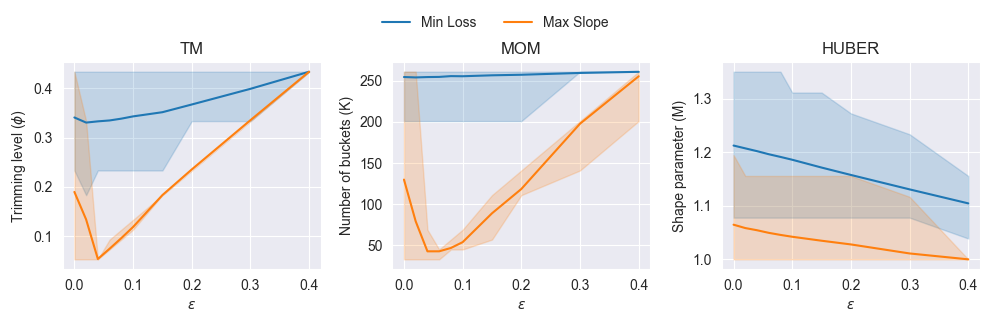

In [195]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

c1 = sns.lineplot(
    df_cv[ (df_cv["method"] == "TM") & (df_cv.algorithm == "plugin" ) ],
    x = "eps",
    y = "best_param",
    hue = "cv_strategy",
    estimator = np.mean, 
    errorbar = lambda x: (np.quantile(x, 0.05), np.quantile(x, 0.95)),
    ax = axs[0]
)
axs[0].set_ylabel(r"Trimming level ($\phi$)")
axs[0].set_title("TM")


c2 = sns.lineplot(
    df_cv[ (df_cv["method"] == "MOM") & (df_cv.algorithm == "plugin" ) ],
    x = "eps",
    y = "best_param",
    hue = "cv_strategy",
    estimator = np.mean, 
    errorbar = lambda x: (np.quantile(x, 0.05), np.quantile(x, 0.95)),
    ax = axs[1]
)
axs[1].set_ylabel("Number of buckets (K)")
axs[1].set_title("MOM")

c2 = sns.lineplot(
    df_cv[ (df_cv["method"] == "HUBER") & (df_cv.algorithm == "admm" ) ],
    x = "eps",
    y = "best_param",
    hue = "cv_strategy",
    estimator = np.mean, 
    errorbar = lambda x: (np.quantile(x, 0.05), np.quantile(x, 0.95)),
    ax = axs[2]
)
axs[2].set_ylabel("Shape parameter (M)")
axs[2].set_title("HUBER")

lines, _ = axs[0].get_legend_handles_labels()
labels = ["Min Loss", "Max Slope"]
fig.legend(lines, labels, ncol=2, loc = 'upper center', bbox_to_anchor = (0, 0.08, 1, 1), frameon=False)

for ax in axs:
    ax.get_legend().set_visible(False)
    ax.set_xlabel(r"$\varepsilon$")

plt.tight_layout()
plt.savefig(f"plots/cv_strategy_selection.pdf", bbox_inches='tight', pad_inches=0)

# Experimental results

## Setup A

We start loading the data from setup A experiments:

In [231]:
df = pd.concat([
    pd.DataFrame(json.load(open(f"results/setupA_plugin.json", "r"))),
    pd.DataFrame(json.load(open(f"results/setupA_admm.json", "r"))),
])

# notice that the algorithm selection is meaningless for huber regression,
# it is here only to keep notation.  the same holds for ols and quantile.
df = df[ df.beta_strategy == "best" ]
df = df[
    ((df["method"] == "TM") & (df["algorithm"] == "plugin") & (df["cv_strategy"] == "max_slope")) |
    ((df["method"] == "MOM") & (df["algorithm"] == "plugin") & (df["cv_strategy"] == "max_slope")) |
    ((df["method"] == "HUBER") & (df["algorithm"] == "admm") & (df["cv_strategy"] == "min_loss")) |
    ((df["method"] == "OLS") & (df["algorithm"] == "admm") & (df["cv_strategy"] == "min_loss")) |
    ((df["method"] == "QUANTILE") & (df["algorithm"] == "admm") & (df["cv_strategy"] == "min_loss"))
]

df['distribution'] = df.apply(format_distribution, axis=1)
df['eps'] = df['sample_contaminated']/df['sample_size']
del df["params"]
del df["beta_hat"]
del df["time"]
del df["type"]
del df["block_kind"]
del df["beta_strategy"]
del df["algorithm"]
del df["cv_strategy"]

# this dataframe now contains the best representant of each method in all distributions of interest
df

,seed,method,L2_dist,best_param,sample_size,sample_contaminated,alpha,skew,heteroscedasticity,distribution,eps
2,1,TM,0.507822,0.433333,300,0,inf,0.0,False,"$(\infty, 0.0)$",0.0
6,2,TM,0.297254,0.183333,300,0,inf,0.0,False,"$(\infty, 0.0)$",0.0
10,3,TM,0.382209,0.093333,300,0,inf,0.0,False,"$(\infty, 0.0)$",0.0
14,4,TM,0.609539,0.433333,300,0,inf,0.0,False,"$(\infty, 0.0)$",0.0
18,5,TM,0.421756,0.333333,300,0,inf,0.0,False,"$(\infty, 0.0)$",0.0
...,...,...,...,...,...,...,...,...,...,...,...
614380,92,HUBER,1.471484,1.077778,300,120,2,0.9,True,"$(2, 0.9)$ ht.",0.4
614384,93,HUBER,2.075919,1.077778,300,120,2,0.9,True,"$(2, 0.9)$ ht.",0.4
614388,94,HUBER,1.322872,1.077778,300,120,2,0.9,True,"$(2, 0.9)$ ht.",0.4
614392,95,HUBER,1.492528,1.077778,300,120,2,0.9,True,"$(2, 0.9)$ ht.",0.4


### Heatmap results

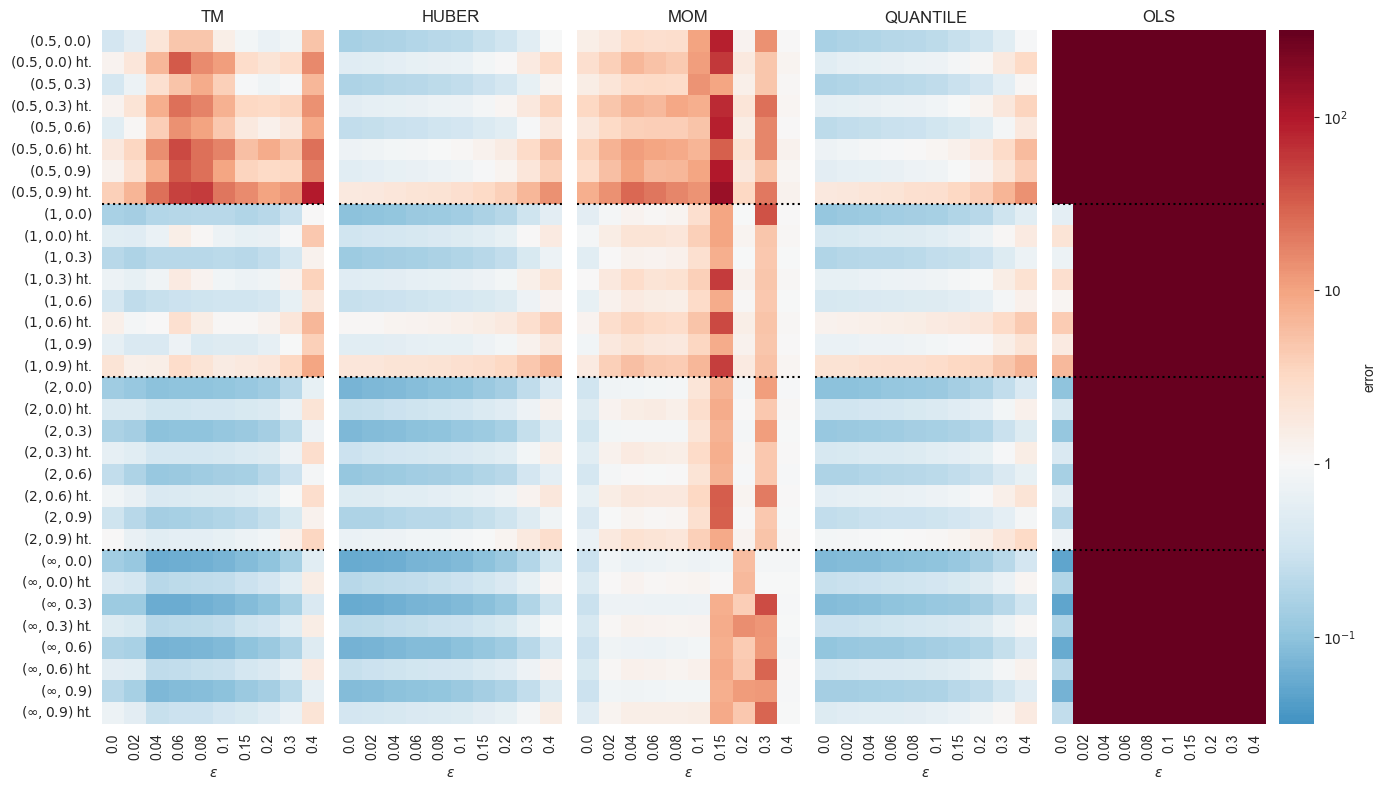

In [232]:
df_mean = df.groupby(['distribution', 'eps', 'method'])['L2_dist'].mean().reset_index()

method_matrices = {
    method: df_mean[df_mean['method'] == method].pivot(index='distribution', columns='eps', values='L2_dist')
    for method in df_mean['method'].unique()
}

fig, axs = plt.subplots(ncols=5, figsize=(14, 8), sharey=True, width_ratios=[1, 1, 1, 1, 1.2])
for ax, method in zip(axs.flat, ["TM", "HUBER", "MOM", "QUANTILE", "OLS"]):
    sns.heatmap(
        np.log(method_matrices[method]),
        cmap="RdBu_r", center=0, ax=ax, vmin=-1.5, vmax=2.5,
        cbar= method == "OLS",
        cbar_kws={'label': 'error'},
    )
    ax.hlines([8, 16, 24], *ax.get_xlim(), colors="black", linestyles=":")
    ax.set_xlabel(r"$\varepsilon$")
    ax.set_ylabel("")
    ax.set_title(method)
    if method=="OLS":
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([-1,0,1,2])
        colorbar.set_ticklabels([r"$10^{-1}$","1",r"$10$",r"$10^{2}$"])
    
plt.tight_layout()
plt.savefig(f"plots/error_plots.pdf", bbox_inches='tight', pad_inches=0)

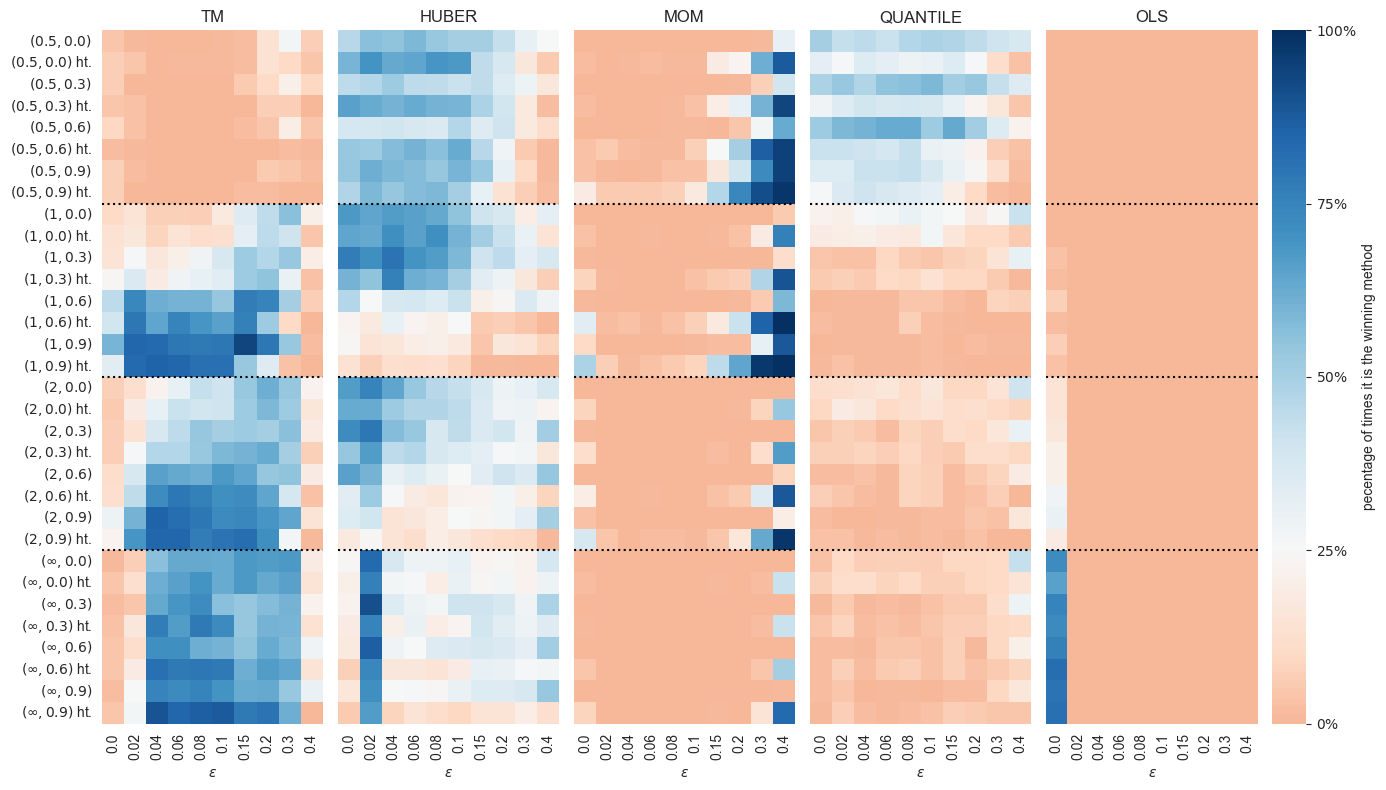

In [233]:
df_best = df.loc[df.groupby(['seed', 'distribution', 'eps'])['L2_dist'].idxmin(), ['seed', 'distribution', 'eps', 'method']]
method_counts = df_best.groupby(['distribution', 'eps', 'method']).size().unstack(fill_value=0)
method_percentages = method_counts.div(method_counts.sum(axis=1), axis=0)
method_matrices = {
    method: method_percentages[[method]].reset_index().pivot(index='distribution', columns='eps', values=method)
    for method in df['method'].unique()
}

fig, axs = plt.subplots(ncols=5, figsize=(14, 8), sharey=True, width_ratios=[1, 1, 1, 1, 1.2])
for ax, method in zip(axs.flat, ["TM", "HUBER", "MOM", "QUANTILE", "OLS"]):
    sns.heatmap(
        method_matrices[method],
        cmap="RdBu", center=.25, ax=ax, vmin=0, vmax=1,
        cbar= method == "OLS",
        cbar_kws={'label': 'pecentage of times it is the winning method'},
    )
    ax.hlines([8, 16, 24], *ax.get_xlim(), colors="black", linestyles=":")
    ax.set_xlabel(r"$\varepsilon$")
    ax.set_ylabel("")
    ax.set_title(method)
    if method=="OLS":
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([0,.25,.5, .75, 1])
        colorbar.set_ticklabels([r"$0\%$",r"$25\%$",r"$50\%$",r"$75\%$", r"$100\%$"])
    
plt.tight_layout()
plt.savefig(f"plots/winning_method.pdf", bbox_inches='tight', pad_inches=0)

### Parameter selection by crossvalidation

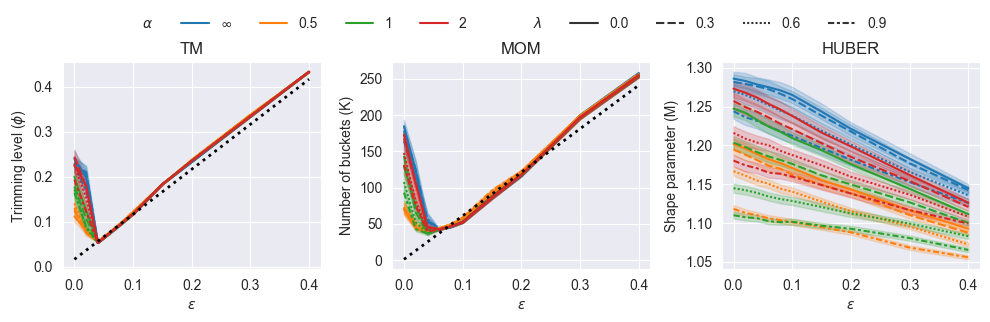

In [295]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))

c1 = sns.lineplot(df[ df["method"] == "TM" ], x="eps", y="best_param", hue="alpha", style="skew", ax=axs[0])
axs[0].plot([0,.4], [0 + 5/300,.4 + 5/300], c="black", ls=":", lw=2)
axs[0].set_ylabel(r"Trimming level ($\phi$)")
axs[0].set_title("TM")


c2 = sns.lineplot(df[ df["method"] == "MOM" ], x="eps", y="best_param", hue="alpha", style="skew", ax=axs[1])
axs[1].plot([0,.4], [1, 300*.8+1], c="black", ls=":", lw=2)
axs[1].set_ylabel("Number of buckets (K)")
axs[1].set_title("MOM")

c3 = sns.lineplot(df[ df["method"] == "HUBER" ], x="eps", y="best_param", hue="alpha", style="skew", ax=axs[2])
axs[2].set_ylabel("Shape parameter (M)")
axs[2].set_title("HUBER")

lines, labels = axs[0].get_legend_handles_labels()
labels[0] = r"$\alpha$"
labels[1] = r"$\infty$"
labels[5] = r"$\lambda$"
fig.legend(lines, labels, ncol=10, loc = 'upper center', bbox_to_anchor = (0, 0.08, 1, 1), frameon=False)

for ax in axs:
    ax.get_legend().set_visible(False)
    ax.set_xlabel(r"$\varepsilon$")

plt.tight_layout()
plt.savefig(f"plots/best_param.pdf", bbox_inches='tight', pad_inches=0)

### Tables for main text

In [235]:
# load data of the eps zero
df_nocv = pd.DataFrame(json.load(open(f"results/setupA_plugin_eps_zero.json", "r")))

# notice that the algorithm selection is meaningless for huber regression,
# it is here only to keep notation.  the same holds for ols and quantile.
df_nocv = df_nocv[ df_nocv.beta_strategy == "best" ]
df_nocv = df_nocv[
    ((df_nocv["method"] == "TM") & (df_nocv["algorithm"] == "plugin") & (df_nocv["cv_strategy"] == "max_slope")) |
    ((df_nocv["method"] == "MOM") & (df_nocv["algorithm"] == "plugin") & (df_nocv["cv_strategy"] == "max_slope")) |
    ((df_nocv["method"] == "HUBER") & (df_nocv["algorithm"] == "plugin") & (df_nocv["cv_strategy"] == "min_loss")) |
    ((df_nocv["method"] == "OLS") & (df_nocv["algorithm"] == "plugin") & (df_nocv["cv_strategy"] == "min_loss")) |
    ((df_nocv["method"] == "QUANTILE") & (df_nocv["algorithm"] == "plugin") & (df_nocv["cv_strategy"] == "min_loss"))
]

df_nocv['distribution'] = df_nocv.apply(format_distribution, axis=1)
del df_nocv["params"]
del df_nocv["beta_hat"]
del df_nocv["time"]
del df_nocv["type"]
del df_nocv["block_kind"]
del df_nocv["beta_strategy"]
del df_nocv["algorithm"]
del df_nocv["cv_strategy"]

# this dataframe now contains the best representant of each method in all distributions of interest
df_nocv

,seed,method,L2_dist,best_param,sample_size,sample_contaminated,alpha,skew,heteroscedasticity,distribution
2,1,TM,0.237966,0.016667,300,0,inf,0.0,False,"$(\infty, 0.0)$"
6,2,TM,0.361647,0.016667,300,0,inf,0.0,False,"$(\infty, 0.0)$"
10,3,TM,0.197269,0.016667,300,0,inf,0.0,False,"$(\infty, 0.0)$"
14,4,TM,0.263068,0.016667,300,0,inf,0.0,False,"$(\infty, 0.0)$"
18,5,TM,0.319011,0.016667,300,0,inf,0.0,False,"$(\infty, 0.0)$"
...,...,...,...,...,...,...,...,...,...,...
107500,92,HUBER,0.787080,1.35,300,0,2,0.9,True,"$(2, 0.9)$ ht."
107504,93,HUBER,0.840071,1.35,300,0,2,0.9,True,"$(2, 0.9)$ ht."
107508,94,HUBER,1.164071,1.35,300,0,2,0.9,True,"$(2, 0.9)$ ht."
107512,95,HUBER,0.734104,1.35,300,0,2,0.9,True,"$(2, 0.9)$ ht."


In [238]:
# get the table for the case with no crossvalidation
df_latex = df_nocv[ (df_nocv.alpha != 2) & (df_nocv["skew"].isin([0, .3, .6, .9])) ].groupby(['method', 'alpha', 'skew'])['L2_dist'].mean().reset_index()
df_latex = df_latex.pivot(index='method', columns=['alpha', 'skew'], values='L2_dist')

for col in df_latex.columns:
    min_value = df_latex[col].min()
    df_latex[col] = df_latex[col].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == min_value else x)

print(df_latex.to_latex(index=True, float_format="{:.2f}".format, escape=False))

\begin{tabular}{lllllllllllll}
\toprule
alpha & \multicolumn{4}{r}{0.500000} & \multicolumn{4}{r}{1} & \multicolumn{4}{r}{inf} \\
skew & 0.000000 & 0.300000 & 0.600000 & 0.900000 & 0.000000 & 0.300000 & 0.600000 & 0.900000 & 0.000000 & 0.300000 & 0.600000 & 0.900000 \\
method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
HUBER & 0.63 & 0.67 & 0.81 & 1.16 & \textbf{0.49} & \textbf{0.54} & \textbf{0.68} & \textbf{0.83} & 0.39 & 0.39 & 0.42 & 0.45 \\
MOM & 4.30 & 4.82 & 6.14 & 7.78 & 1.22 & 1.33 & 1.45 & 1.72 & 0.65 & 0.64 & 0.68 & 0.69 \\
OLS & 22.91 & 27.50 & 34.51 & 42.17 & 1.10 & 1.19 & 1.46 & 1.75 & \textbf{0.37} & \textbf{0.37} & \textbf{0.39} & \textbf{0.42} \\
QUANTILE & \textbf{0.61} & \textbf{0.63} & \textbf{0.71} & \textbf{1.04} & 0.52 & 0.65 & 0.89 & 1.15 & 0.45 & 0.46 & 0.51 & 0.57 \\
TM & 1.82 & 1.97 & 2.49 & 3.34 & 0.64 & 0.65 & 0.74 & 0.86 & 0.39 & 0.38 & 0.40 & 0.43 \\
\bottomrule
\end{tabular}



In [244]:
# get the table for the case with cv and eps = .1
df_latex = df[ (df.alpha != 2) & (df["skew"].isin([0, .3, .6, .9])) & (df["eps"] == .1) ].groupby(['method', 'alpha', 'skew'])['L2_dist'].mean().reset_index()
df_latex = df_latex.pivot(index='method', columns=['alpha', 'skew'], values='L2_dist')

for col in df_latex.columns:
    min_value = df_latex[col].min()
    df_latex[col] = df_latex[col].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == min_value else x)

print(df_latex.to_latex(index=True, float_format="{:.2f}".format, escape=False))

\begin{tabular}{lllllllllllll}
\toprule
alpha & \multicolumn{4}{r}{0.500000} & \multicolumn{4}{r}{1} & \multicolumn{4}{r}{inf} \\
skew & 0.000000 & 0.300000 & 0.600000 & 0.900000 & 0.000000 & 0.300000 & 0.600000 & 0.900000 & 0.000000 & 0.300000 & 0.600000 & 0.900000 \\
method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
HUBER & \textbf{0.69} & \textbf{0.72} & \textbf{0.83} & \textbf{1.20} & \textbf{0.56} & \textbf{0.66} & 0.89 & 1.16 & 0.46 & 0.46 & 0.51 & 0.56 \\
MOM & 2.77 & 2.78 & 2.19 & 2.85 & 1.66 & 1.64 & 1.82 & 2.01 & 0.98 & 0.99 & 1.04 & 1.07 \\
OLS & 91.96 & 95.35 & 99.89 & 104.36 & 82.88 & 82.91 & 82.94 & 82.93 & 82.91 & 82.91 & 82.91 & 82.91 \\
QUANTILE & 0.70 & 0.72 & 0.84 & 1.23 & 0.59 & 0.72 & 0.99 & 1.25 & 0.50 & 0.52 & 0.58 & 0.63 \\
TM & 2.01 & 2.10 & 2.72 & 3.25 & 0.68 & 0.71 & \textbf{0.83} & \textbf{0.98} & \textbf{0.43} & \textbf{0.43} & \textbf{0.45} & \textbf{0.49} \\
\bottomrule
\end{tabular}



In [245]:
# get the table for the case with cv and eps = .2
df_latex = df[ (df.alpha != 2) & (df["skew"].isin([0, .3, .6, .9])) & (df["eps"] == .2) ].groupby(['method', 'alpha', 'skew'])['L2_dist'].mean().reset_index()
df_latex = df_latex.pivot(index='method', columns=['alpha', 'skew'], values='L2_dist')

for col in df_latex.columns:
    min_value = df_latex[col].min()
    df_latex[col] = df_latex[col].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == min_value else x)

print(df_latex.to_latex(index=True, float_format="{:.2f}".format, escape=False))

\begin{tabular}{lllllllllllll}
\toprule
alpha & \multicolumn{4}{r}{0.500000} & \multicolumn{4}{r}{1} & \multicolumn{4}{r}{inf} \\
skew & 0.000000 & 0.300000 & 0.600000 & 0.900000 & 0.000000 & 0.300000 & 0.600000 & 0.900000 & 0.000000 & 0.300000 & 0.600000 & 0.900000 \\
method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
HUBER & \textbf{0.81} & 0.85 & 1.00 & \textbf{1.44} & \textbf{0.65} & 0.74 & 1.00 & 1.29 & 0.54 & 0.53 & 0.58 & 0.64 \\
MOM & 1.18 & 1.27 & 1.33 & 1.51 & 1.03 & 1.06 & 1.11 & 1.18 & 2.21 & 2.53 & 1.91 & 2.45 \\
OLS & 123.40 & 126.44 & 130.71 & 134.85 & 114.59 & 114.61 & 114.64 & 114.65 & 114.61 & 114.60 & 114.60 & 114.61 \\
QUANTILE & 0.82 & \textbf{0.85} & \textbf{1.00} & 1.47 & 0.68 & 0.79 & 1.08 & 1.37 & 0.58 & 0.58 & 0.65 & 0.72 \\
TM & 1.14 & 1.27 & 1.84 & 2.20 & 0.67 & \textbf{0.72} & \textbf{0.88} & \textbf{1.08} & \textbf{0.50} & \textbf{0.50} & \textbf{0.54} & \textbf{0.59} \\
\bottomrule
\end{tabular}



In [247]:
# get the table for the case with cv and eps = .4
df_latex = df[ (df.alpha != 2) & (df["skew"].isin([0, .3, .6, .9])) & (df["eps"] == .4) ].groupby(['method', 'alpha', 'skew'])['L2_dist'].mean().reset_index()
df_latex = df_latex.pivot(index='method', columns=['alpha', 'skew'], values='L2_dist')

for col in df_latex.columns:
    min_value = df_latex[col].min()
    df_latex[col] = df_latex[col].apply(lambda x: f"\\textbf{{{x:.2f}}}" if x == min_value else x)

print(df_latex.to_latex(index=True, float_format="{:.2f}".format, escape=False))

\begin{tabular}{lllllllllllll}
\toprule
alpha & \multicolumn{4}{r}{0.500000} & \multicolumn{4}{r}{1} & \multicolumn{4}{r}{inf} \\
skew & 0.000000 & 0.300000 & 0.600000 & 0.900000 & 0.000000 & 0.300000 & 0.600000 & 0.900000 & 0.000000 & 0.300000 & 0.600000 & 0.900000 \\
method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
HUBER & 1.30 & 1.40 & 1.74 & 2.47 & 1.01 & 1.14 & 1.47 & 1.84 & \textbf{0.83} & \textbf{0.80} & \textbf{0.86} & \textbf{0.95} \\
MOM & \textbf{1.04} & \textbf{1.04} & \textbf{1.06} & \textbf{1.08} & 1.02 & \textbf{1.01} & \textbf{1.02} & \textbf{1.03} & 0.98 & 0.99 & 0.99 & 0.98 \\
OLS & 174.24 & 177.37 & 180.77 & 184.51 & 166.96 & 166.99 & 167.01 & 167.03 & 166.99 & 166.98 & 166.98 & 166.98 \\
QUANTILE & 1.30 & 1.38 & 1.74 & 2.48 & \textbf{1.01} & 1.16 & 1.53 & 1.89 & 0.84 & 0.82 & 0.91 & 1.00 \\
TM & 2.67 & 2.69 & 3.29 & 5.34 & 1.48 & 1.45 & 1.81 & 2.24 & 0.97 & 0.94 & 0.98 & 1.10 \\
\bottomrule
\end{tabular}



### When to choose each strategy?

/tmp/ipykernel_91555/2725317187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t.alpha[ df_t.alpha == "inf" ] = 4
/tmp/ipykernel_91555/2725317187.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['heteroscedasticity'] = X['heteroscedasticity'].astype(int)


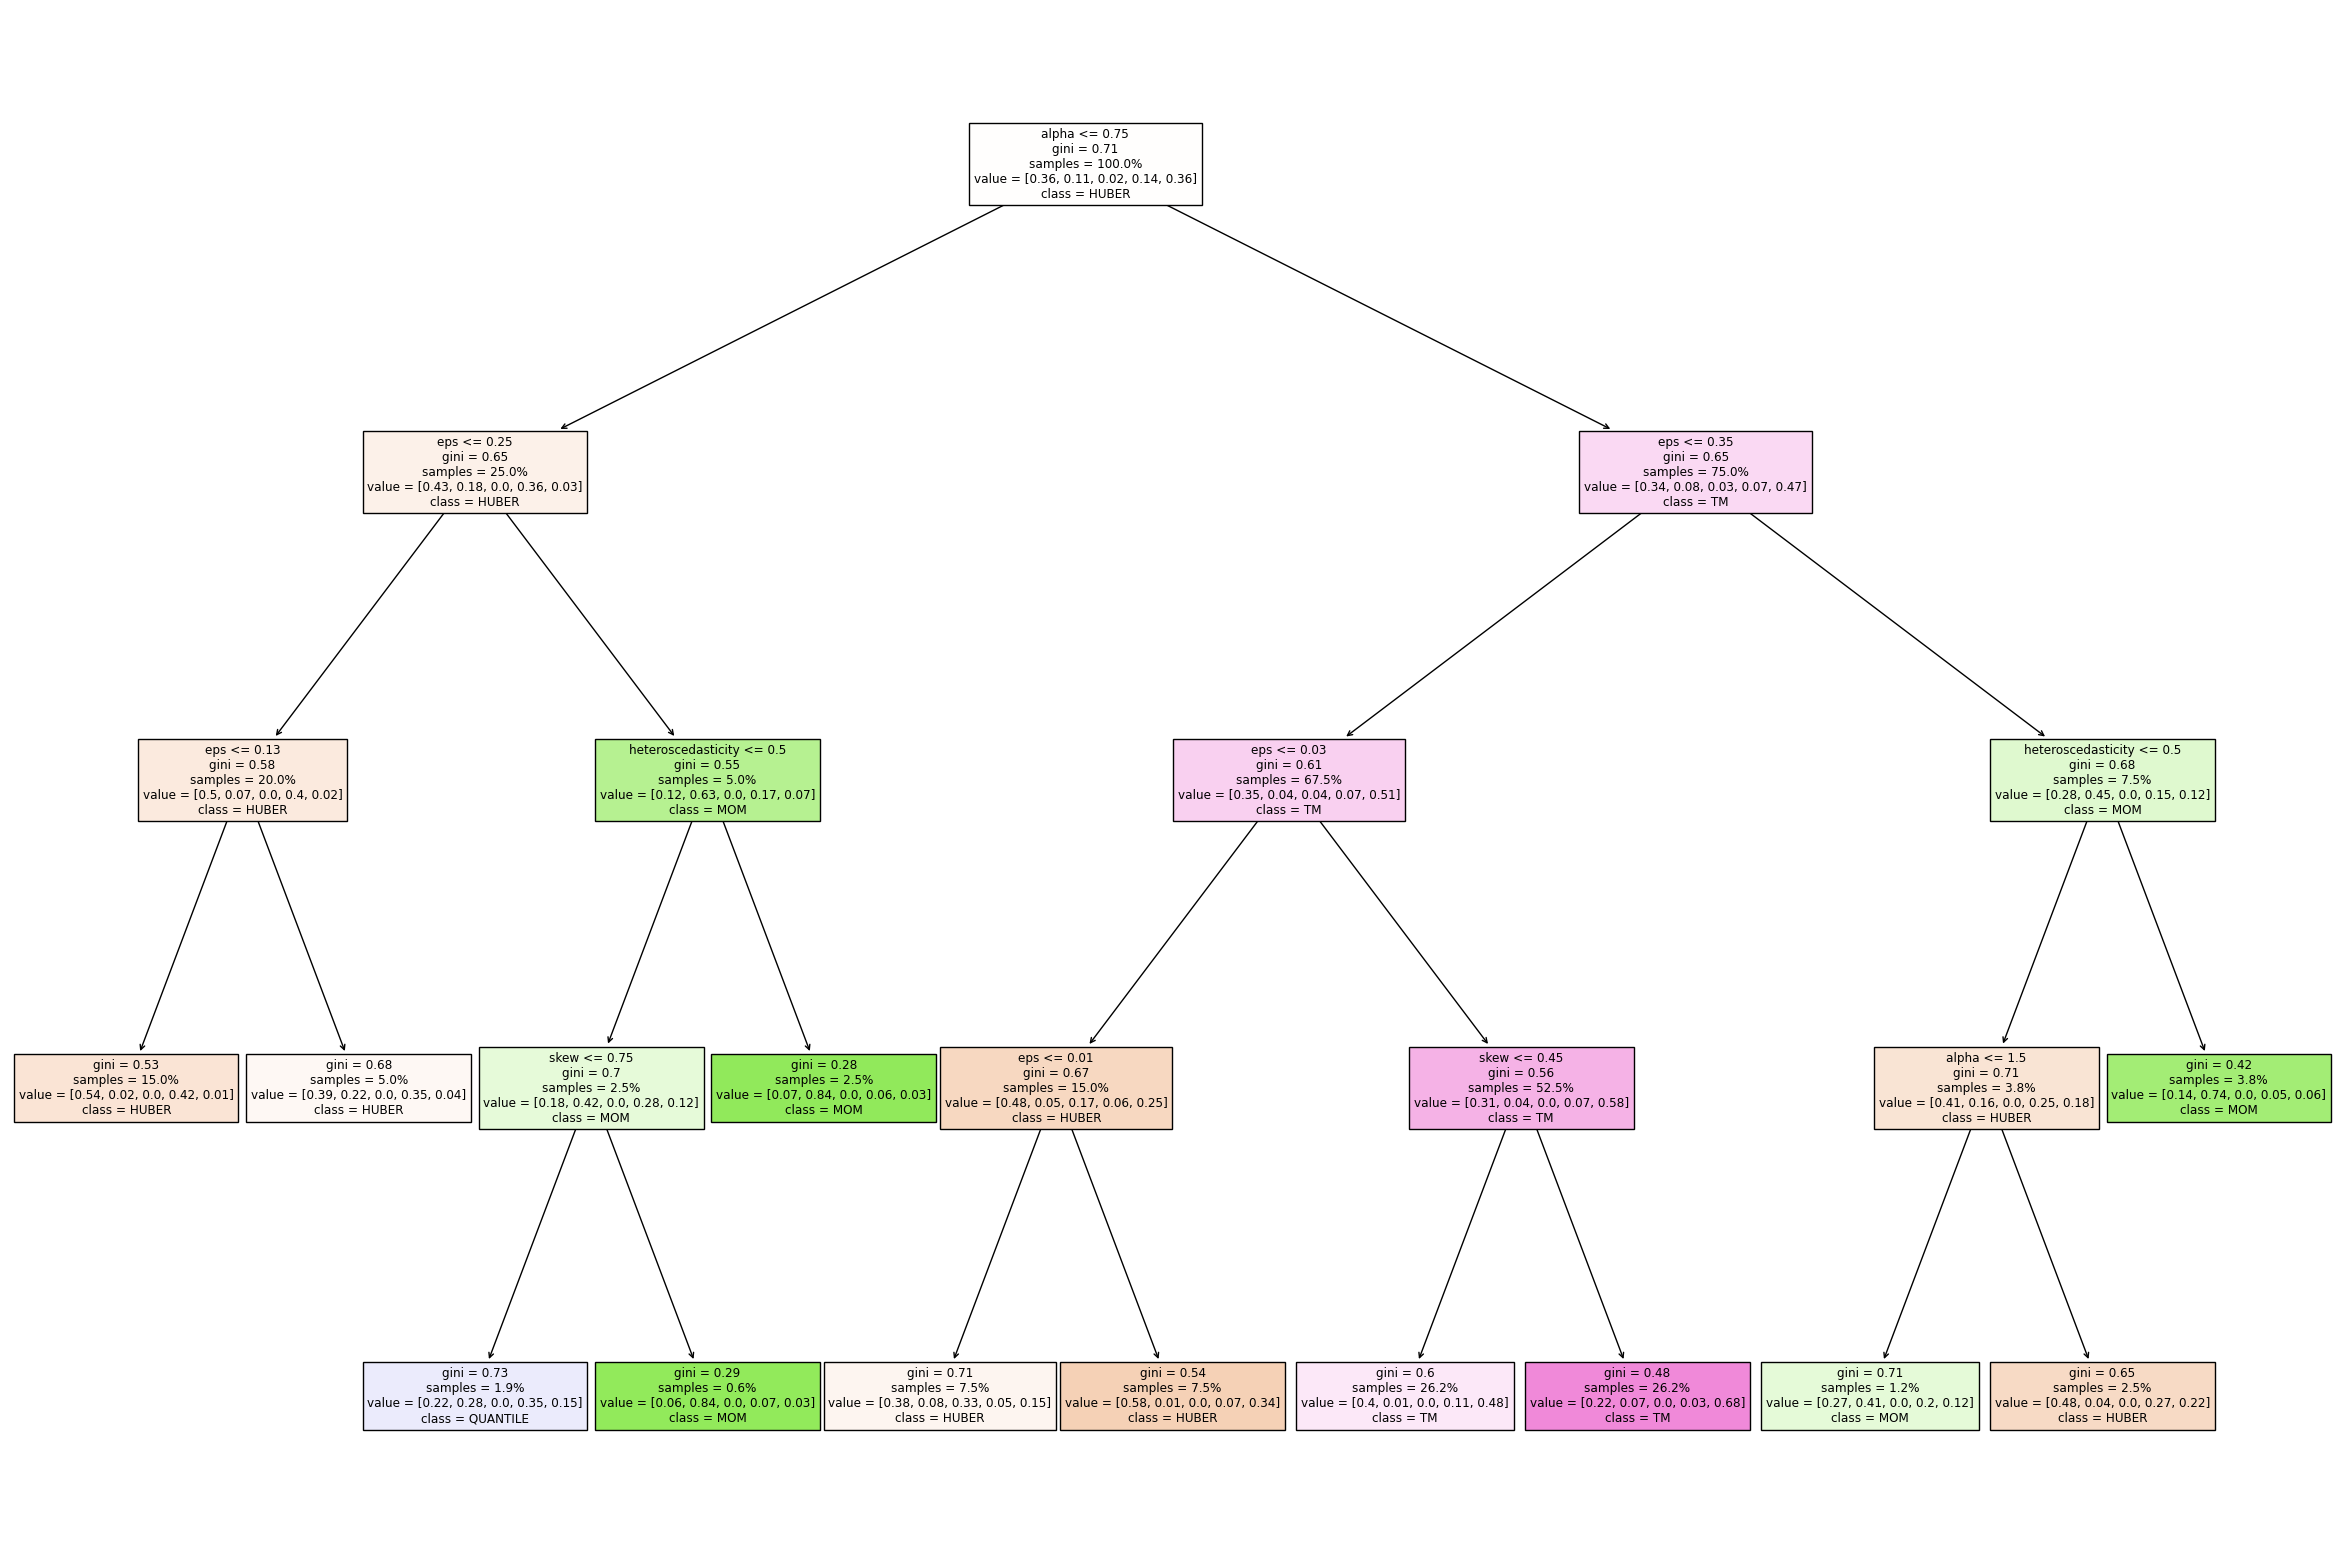

In [144]:
df_t = df[ df["method"].isin(["TM", "HUBER", "QUANTILE", "MOM", "OLS"]) ]
df_t.alpha[ df_t.alpha == "inf" ] = 4

# Group by the relevant columns and find the row with the smallest L2_dist
df_t = df_t.loc[df_t.groupby(['seed', 'eps', 'alpha', 'skew', 'heteroscedasticity'])['L2_dist'].idxmin()]
df_t = df_t[['seed', 'eps', 'alpha', 'skew', 'heteroscedasticity', 'method']]

# Assuming df_t is your DataFrame
X = df_t[['eps', 'alpha', 'skew', 'heteroscedasticity']]  # Features
y = df_t['method']  # Target variable (multi-class)

# Convert categorical variables if necessary
if df_t['heteroscedasticity'].dtype == 'bool':
    X['heteroscedasticity'] = X['heteroscedasticity'].astype(int)

# Encode method labels as numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert "TM", "HUBER", etc., to integers

# Fit a small decision tree
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=1, max_leaf_nodes=12)  # Limit depth to keep it interpretable
tree_clf.fit(X, y_encoded)

# Plot the decision tree
plt.figure(figsize=(30, 20))
plot_tree(tree_clf, feature_names=X.columns, class_names=label_encoder.classes_, filled=True, precision=2, proportion=True)
plt.show()

## Setup B

In [259]:
df_B = pd.DataFrame(json.load(open(f"results/setupB.json", "r")))


# notice that the algorithm selection is meaningless for huber regression,
# it is here only to keep notation.  the same holds for ols and quantile.
df_B = df_B[ df_B.beta_strategy == "best" ]
df_B = df_B[
    ((df_B["method"] == "TM") & (df_B["cv_strategy"] == "max_slope")) |
    ((df_B["method"] == "MOM") & (df_B["cv_strategy"] == "max_slope")) |
    ((df_B["method"] == "HUBER") & (df_B["cv_strategy"] == "min_loss")) |
    ((df_B["method"] == "OLS") & (df_B["cv_strategy"] == "min_loss")) |
    ((df_B["method"] == "QUANTILE") & (df_B["cv_strategy"] == "min_loss"))
]

df_B['eps'] = df_B['sample_contaminated']/df_B['sample_size']
del df_B["params"]
del df_B["beta_hat"]
del df_B["time"]
del df_B["type"]
del df_B["block_kind"]
del df_B["beta_strategy"]
del df_B["algorithm"]
del df_B["cv_strategy"]

# this dataframe now contains the best representant of each method in all distributions of interest
df_B

,seed,method,L2_dist,best_param,sample_size,sample_contaminated,p,eps
2,1,TM,0.049732,0.03,1000,0,0.05,0.00
6,2,TM,0.039826,0.05,1000,0,0.05,0.00
10,3,TM,0.056532,0.05,1000,0,0.05,0.00
14,4,TM,0.090763,0.05,1000,0,0.05,0.00
18,5,TM,0.058473,0.03,1000,0,0.05,0.00
...,...,...,...,...,...,...,...,...
30700,92,QUANTILE,0.447214,-,1000,140,0.09,0.14
30704,93,QUANTILE,0.447214,-,1000,140,0.09,0.14
30708,94,QUANTILE,0.447214,-,1000,140,0.09,0.14
30712,95,QUANTILE,0.447214,-,1000,140,0.09,0.14


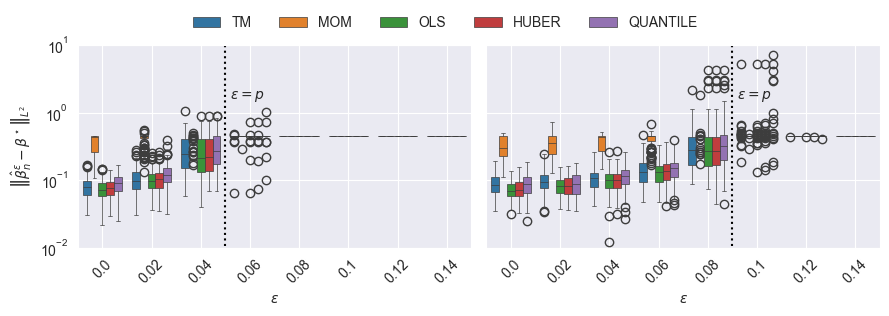

In [299]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 3), sharey=True)

c1 = sns.boxplot(df_B[ df_B.p == 0.05 ], y="L2_dist", x="eps", hue="method", ax=axs[0], linewidth=0.5).set(
    xlabel=r"$\varepsilon$", ylabel=r"$\left\| \hat{\beta}_n^\varepsilon - \beta^\star \right\|_{L^2}$"
)
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_yscale("log")
axs[0].set_ylim(.01, 10)
axs[0].grid(True, axis='both')
axs[0].axvline(x=2.5, ymin=.01, ymax=10, c="black", ls=":")
axs[0].text(2.5 + .1, 1.6, r"$\varepsilon = p$")

c2 = sns.boxplot(df_B[ df_B.p == 0.09 ], y="L2_dist", x="eps", hue="method", ax=axs[1], linewidth=0.5).set(
    xlabel=r"$\varepsilon$"
)
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True, axis='both')
axs[1].axvline(x=4.5, ymin=.01, ymax=10, c="black", ls=":")
axs[1].text(4.5 + .1, 1.6, r"$\varepsilon = p$")

lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines, labels, ncol=5, loc = 'upper center', bbox_to_anchor = (0, 0.06, 1, 1), frameon=False)

for ax in axs:
    ax.get_legend().set_visible(False)
    ax.set_xlabel(r"$\varepsilon$")

plt.tight_layout()
plt.savefig(f"plots/setupB.pdf", bbox_inches='tight', pad_inches=0)